In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def plt_fields2(filename,layer=2): # give lr_filename
    
    # lr
    dd = np.load(filename)
    layer0 = 4 + int(layer/2)
    dx_lr = dd[0][0,4:84,4:84,layer0]
    
    # hr
    hr_file = filename.replace('lr','hr',1)
    dd = np.load(hr_file)
    dx_hr = dd[0][0,:,:,layer]
    
    # sr
    sr_file = filename.replace('lr','sr',1)
    dd = np.load(sr_file)
    dx_sr = dd[0][0,:,:,layer]
    
    vmx = np.max(dx_hr)
    vmn = np.min(dx_hr)
    
    print ("residual:",np.average(dx_sr - dx_hr))
    ######################################################
    
    f, axes = plt.subplots(1,3,figsize=[14,4])
    f.subplots_adjust(hspace=0.1,wspace=0.4)
    
    ax = axes.flat[0]  
    img1 = ax.imshow(dx_hr,vmax=vmx,vmin=vmn)
    ax.set_title('hr_dx field',fontsize=15)
    ax.set_yticks([])
    
    ax = axes.flat[1]  
    img2 = ax.imshow(dx_sr,vmax=vmx,vmin=vmn)
    ax.set_title('sr_dx field',fontsize=15)
    ax.set_yticks([])
    
    ax = axes.flat[2]  
#     img3 = ax.imshow(dx_sr - dx_hr,cmap = 'Pastel2')
    img3 = ax.imshow(dx_sr - dx_hr,vmax=0.3,vmin=-0.3,cmap = 'coolwarm')
    ax.set_title('sr - hr',fontsize=15)
    ax.set_yticks([])
       
    ######################################################
    cbar_ax = f.add_axes([0.34, 0.14, 0.01, 0.72])    # rect [left, bottom, width, height]
    cbar = f.colorbar(img1, cax=cbar_ax)
    
    cbar_ax2 = f.add_axes([0.625, 0.14, 0.01, 0.72])    
    cbar = f.colorbar(img2, cax=cbar_ax2)
    
    cbar_ax3 = f.add_axes([0.91, 0.14, 0.01, 0.72])    
    cbar = f.colorbar(img3, cax=cbar_ax3)

residual: -0.017728442


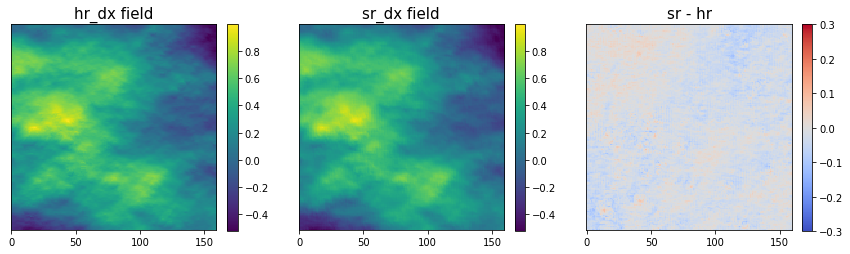

In [16]:
plt_fields2('/home/yueying/scratch1/dmo-srsgan/test3/saved_samples/lr_21000.npy',layer=15)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, SymLogNorm
import torch
import torch.nn.functional as F
import glob, re

def losses(moving_average=100, from_epoch=0):
    files = glob.glob("../srsgan-??????.out")
    losses = []
    for file in files:
        with open(file) as f:
            for l in f.readlines():
                parts = re.findall("[^ \[\]\/\n]+", l)
                if len(parts) == 20:
                    num_epoch = float(parts[1]) + float(parts[4]) / float(parts[5])
                    loss_D = float(parts[8])
                    loss_G = float(parts[11])
                    loss_G_content = float(parts[15])
                    loss_G_adversarial = float(parts[19])
                    losses.append([num_epoch, loss_D, loss_G, loss_G_content, loss_G_adversarial])
    losses = np.asarray(losses).T
    losses = losses.cumsum(axis=1)
    losses = losses[:, moving_average:] - losses[:, : - moving_average]
    losses /= moving_average
    
    losses = losses[:, losses[0] >= from_epoch]
    
    plt.plot(losses[0], losses[1])
    plt.show()
    plt.plot(losses[0], losses[2])
    plt.show()
    plt.plot(losses[0], losses[3])
    plt.show()
    plt.plot(losses[0], losses[4])
    plt.show()

def slices(batches):
    lr = np.load(f"lr_{batches}.npy")
    hr = np.load(f"hr_{batches}.npy")  # already trimmed
    sr = np.load(f"sr_{batches}.npy")
    
    trim_l = (lr.shape[-1] - sr.shape[-1] // 2) // 2
    trim_r = (lr.shape[-1] - sr.shape[-1] // 2 + 1) // 2  # terrible HACK here
    print(f"Trimming {trim_l} on the left, {trim_r} on the right")
    lr = lr[..., trim_l:-trim_r, trim_l:-trim_r, trim_l:-trim_r]
    
    lu = F.interpolate(torch.from_numpy(lr), scale_factor=2, mode='nearest')
    lu = lu.numpy()
    
    cmap = 'RdBu_r'
    norm = Normalize(vmin=-1.5, vmax=1.5)
    norm_d = SymLogNorm(linthresh=0.1, vmin=-1, vmax=1)
    
    mb = lr.shape[0]
    plt.figure(figsize=(20, 6 * mb))
    for b in range(mb):
        plt.subplot(2 * mb, 6, 2 * b * 6 + 1)
        plt.imshow(lr[b, 0, 0], cmap=cmap, norm=norm)
        plt.colorbar()
        plt.subplot(2 * mb, 6, 2 * b * 6 + 2)
        plt.imshow(hr[b, 0, 0], cmap=cmap, norm=norm)
        plt.colorbar()
        plt.subplot(2 * mb, 6, 2 * b * 6 + 3)
        plt.imshow(sr[b, 0, 0], cmap=cmap, norm=norm)
        plt.colorbar()

        plt.subplot(2 * mb, 6, 2 * b * 6 + 8)
        plt.imshow(hr[b, 0, 0] - lu[b, 0, 0], cmap=cmap, norm=norm_d)
        plt.colorbar()
        plt.subplot(2 * mb, 6, 2 * b * 6 + 9)
        plt.imshow(sr[b, 0, 0] - lu[b, 0, 0], cmap=cmap, norm=norm_d)
        plt.colorbar()
        
    print((hr - lu).std(), (sr - lu).std())
        
        
#         plt.subplot(mb, 6, b * 6 + 4)
#         plt.imshow(lr[b, 3, 0], cmap=cmap)
#         plt.colorbar()
#         plt.subplot(mb, 6, b * 6 + 5)
#         plt.imshow(hr[b, 3, 0], cmap=cmap)
#         plt.colorbar()
#         plt.subplot(mb, 6, b * 6 + 6)
#         plt.imshow(sr[b, 3, 0], cmap=cmap)
#         plt.colorbar()